In [3]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("data/trades.db")
df = pd.read_sql_query("SELECT * FROM trades ORDER BY timestamp", conn, parse_dates=["timestamp"])
conn.close()

# Quick peek
df.head()

,id,timestamp,symbol,strategy,side,price,amount,cost,reason
0,1,2025-05-23 18:33:59.098243,SOL/USDT,RsiStrategy,buy,179.82,0.055611,9.999999,None
1,2,2025-05-23 18:53:58.896951,SOL/USDT,RsiStrategy,sell,178.62,0.055611,9.933265,trailing-stop
2,3,2025-05-23 19:08:58.896126,SOL/USDT,RsiStrategy,buy,179.67,0.055658,9.999999,None
3,4,2025-05-23 19:23:58.914072,SOL/USDT,RsiStrategy,sell,179.76,0.055658,10.005008,time-cap
4,5,2025-05-23 20:43:58.869882,SOL/USDT,RsiStrategy,buy,177.51,0.056335,9.999999,None


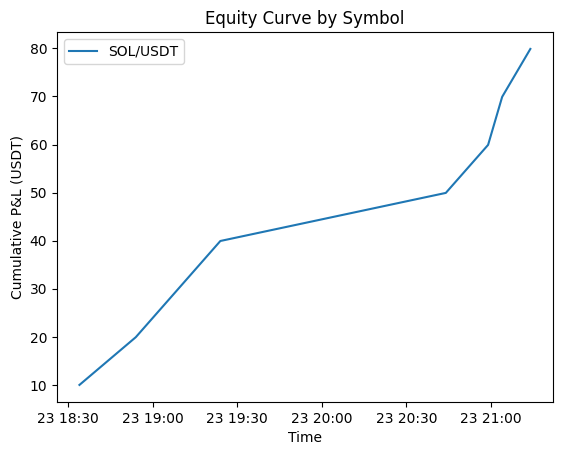

In [4]:
import matplotlib.pyplot as plt

# cumulative P&L by symbol
df["cum_pnl"] = df.groupby("symbol")["cost"].cumsum()

plt.figure()
for sym, grp in df.groupby("symbol"):
    plt.plot(grp["timestamp"], grp["cum_pnl"], label=sym)
plt.legend()
plt.title("Equity Curve by Symbol")
plt.xlabel("Time")
plt.ylabel("Cumulative P&L (USDT)")
plt.show()


In [5]:
import sqlite3
import pandas as pd

# ─── Load live trades from SQLite ─────────────────────────────────────────────
conn = sqlite3.connect("data/trades.db")
df = pd.read_sql_query(
    "SELECT * FROM trades ORDER BY timestamp",
    conn,
    parse_dates=["timestamp"]
)
conn.close()

# ─── Compute P&L summary by symbol & strategy ─────────────────────────────────
summary = df.groupby(["symbol", "strategy"])["cost"] \
            .agg(total_pnl="sum", trades="count") \
            .reset_index()

# Display the result
summary



,symbol,strategy,total_pnl,trades
0,SOL/USDT,RsiStrategy,79.888079,8


In [6]:
# ─── Cell 1: Run Backtest & Load Trades ──────────────────────────────────────
from backtest import run_backtest
from config import FAST_SMA, SLOW_SMA
import pandas as pd

# Run the backtest with your default SMA settings
result = run_backtest(FAST_SMA, SLOW_SMA)

# Build a DataFrame of individual trades
df_trades = pd.DataFrame(result['trades'])
df_trades.head()

Backtest run at 2025-05-23T22:45:12.750410 UTC for FAST=10, SLOW=100
Total trades: 6, Total P&L: -9.15 USDT


,entry_index,exit_index,entry_price,exit_price,pnl
0,112,144,179.00,178.57,-0.966355
1,146,174,179.45,178.20,-1.786476
2,211,213,178.53,178.13,-0.934990
3,220,300,179.68,180.89,0.669146
4,320,368,182.69,179.29,-3.942972


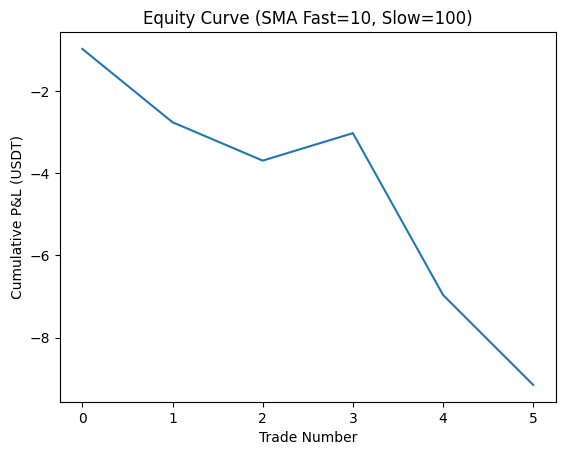

In [7]:
# ─── Cell 2: Equity Curve ───────────────────────────────────────────────────
import matplotlib.pyplot as plt

# Cumulative P&L over each trade
equity = df_trades['pnl'].cumsum()

plt.figure()
plt.plot(equity)
plt.title(f"Equity Curve (SMA Fast={FAST_SMA}, Slow={SLOW_SMA})")
plt.xlabel("Trade Number")
plt.ylabel("Cumulative P&L (USDT)")
plt.show()

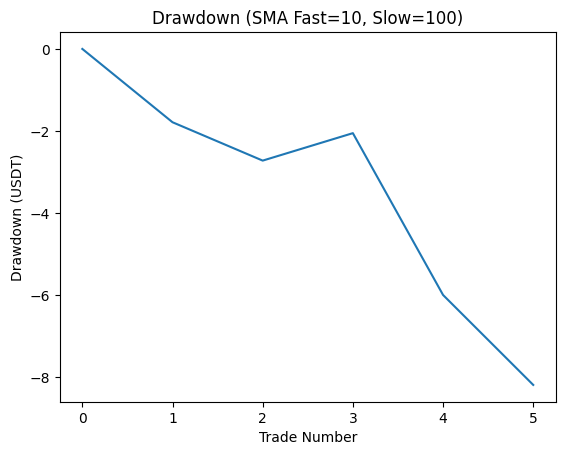

In [8]:
# ─── Cell 3: Drawdown Curve ────────────────────────────────────────────────
# Drawdown = equity − running max equity
high_water = equity.cummax()
drawdown = equity - high_water

plt.figure()
plt.plot(drawdown)
plt.title(f"Drawdown (SMA Fast={FAST_SMA}, Slow={SLOW_SMA})")
plt.xlabel("Trade Number")
plt.ylabel("Drawdown (USDT)")
plt.show()

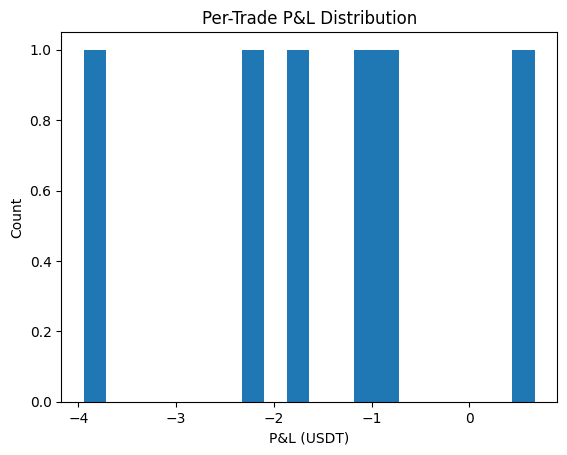

In [9]:
# ─── Cell 4: Per-Trade P&L Distribution ────────────────────────────────────
plt.figure()
plt.hist(df_trades['pnl'], bins=20)
plt.title("Per-Trade P&L Distribution")
plt.xlabel("P&L (USDT)")
plt.ylabel("Count")
plt.show()